## Training of the neural network for X-ray tracks reconstruction

In the following notebook, an hexsample simulation will be extracted, preprocessed and used for training a neural network for inferring the X-ray energy and its hit position.

In [2]:
import os

from IPython import display
# importing the necessary keras modules for model creation, training and saving
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [3]:
# importing the custom libraries
from xrayreco.preprocessing import Xraydata, processing_training_data,\
                                   highest_pixel_coordinates
from hexsample.fileio import ReconInputFile

ModuleNotFoundError: No module named 'xrayreco.preprocessing'

The detector readout is an hexagonal grid, depicted in the figure below.  
The disposition of the hexagonal grid is labelled as `ODD_R` (see https://www.redblobgames.com/grids/hexagons/#coordinates-offset). 

In [ ]:
# Showing the hexagonal grid for reference
display.Image("../figures/Hexagonal_routing_7_HexagonalLayout.ODD_R.png")

In [ ]:
# Loading an hexsample simulation and storing its content into an Xraydata object
file_path = '../../datasets/hxsim_20ENC_01srcsigma.h5'
data = Xraydata(file_path)

In [ ]:
# Printing simulation info
print(data)
repr(data)

The source element is Cu. For our interests, we look at its K-forest that for clarity will be shown.

In [ ]:
# The Xraydata object contains methods for preprocessing that give the
# input and training output for the NN
input_data, target_data = processing_training_data(data)

#### Checking the shape and content of input and target data

In [ ]:
# Printing the input data of the first event and the shape of the overall input
print(input_data[1])
print(input_data.shape)

As we can see, the input data is a numpy array of shape (n, 7, 3), where:
- n is the number of simulated events;
- 7 is the number of pixels of every event track;
- 3 is the number of informations contained in every pixel: (pha, x, y).  
**NB:** the coordinates x,y are _with respect to the pixel with highest signal_! That means that the x and y for every datum are always the same.

In [ ]:
# Printing the target array of the first event and the shape of the overall target array
print(f'Energy = {target_data[0][0]}')
print(f'Hit coordinates : ({target_data[0][1:]})')

In [ ]:
# Selecting the only energies with array slicing
target_data[:,0]

In [ ]:
# Showing the target data energy distribution - As written in the simulation
# informations, the source is a Cu one, emitting two principal lines:
# Ka at 8046 eV and Kb at 8094 eV.
plt.figure()
plt.hist(target_data[:,0], bins=20)
plt.xlabel('Photon energy [eV]')

This specific case suggests a classification task more than a regression one but this is not the most specific case. In this first training, I have trained using this dataset to see if the NN was able to generalize to different energies.

In [ ]:
# Showing the target data x and y distributions
# The beam shape is Gaussian and its sigma has been chosen big enough to illuminate
# the whole pixel, knowing that the pitch is of 60 um.
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
ax1.hist(target_data[:,1], bins=50)
ax1.set(xlabel=r'$x-x_{max}$')
ax2.hist(target_data[:,2], bins=50)
ax2.set(xlabel=r'$y-y_{max}$')


We can see that the distribution of x truncates on both sides at $\frac{p}{2}$ (the pitch of all the analyzed simulation is fixed to 60 $\mu$m). This makes sense: the x-ray hit position always lies on the pixel where the highest charge has been collected.  
The asymmetry between x and y is due to the different sizes of the hexagon on the two directions. In particular, for the `ODD_R` layout, the pitch refers to half the x-direction dimension, that is 30 $\mu \text{m}$ , whereas the y-direction is given by $\frac{2}{\sqrt{3}} \cdot \frac{p}{2}$, that is 34.6 $\mu \text{m}$ .

#### Data rescaling

In [ ]:
# Standardizing input data
# Is the StandardScaler the right choice for a bimodal distribution?
scaler = StandardScaler()
X = scaler.fit_transform(input_data.reshape(-1, input_data.shape[-1])).reshape(input_data.shape)

#### Definition of the FFNN model

In this first training, I have used a single NN with two outputs: the energy and the position with respect to the center of the highest signal pixel.

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 7, 3)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 21)        │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 20)        │        440 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 50)        │      1,050 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 50)        │      2,550 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 50)        │      2,550 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 50)        │      2,550 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 50)        │      2,550 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 10)        │        510 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 30)        │      1,530 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         11 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 2)         │         62 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,803 (53.92 KB)

 Trainable params: 13,803 (53.92 KB)

 Non-trainable params: 0 (0.00 B)

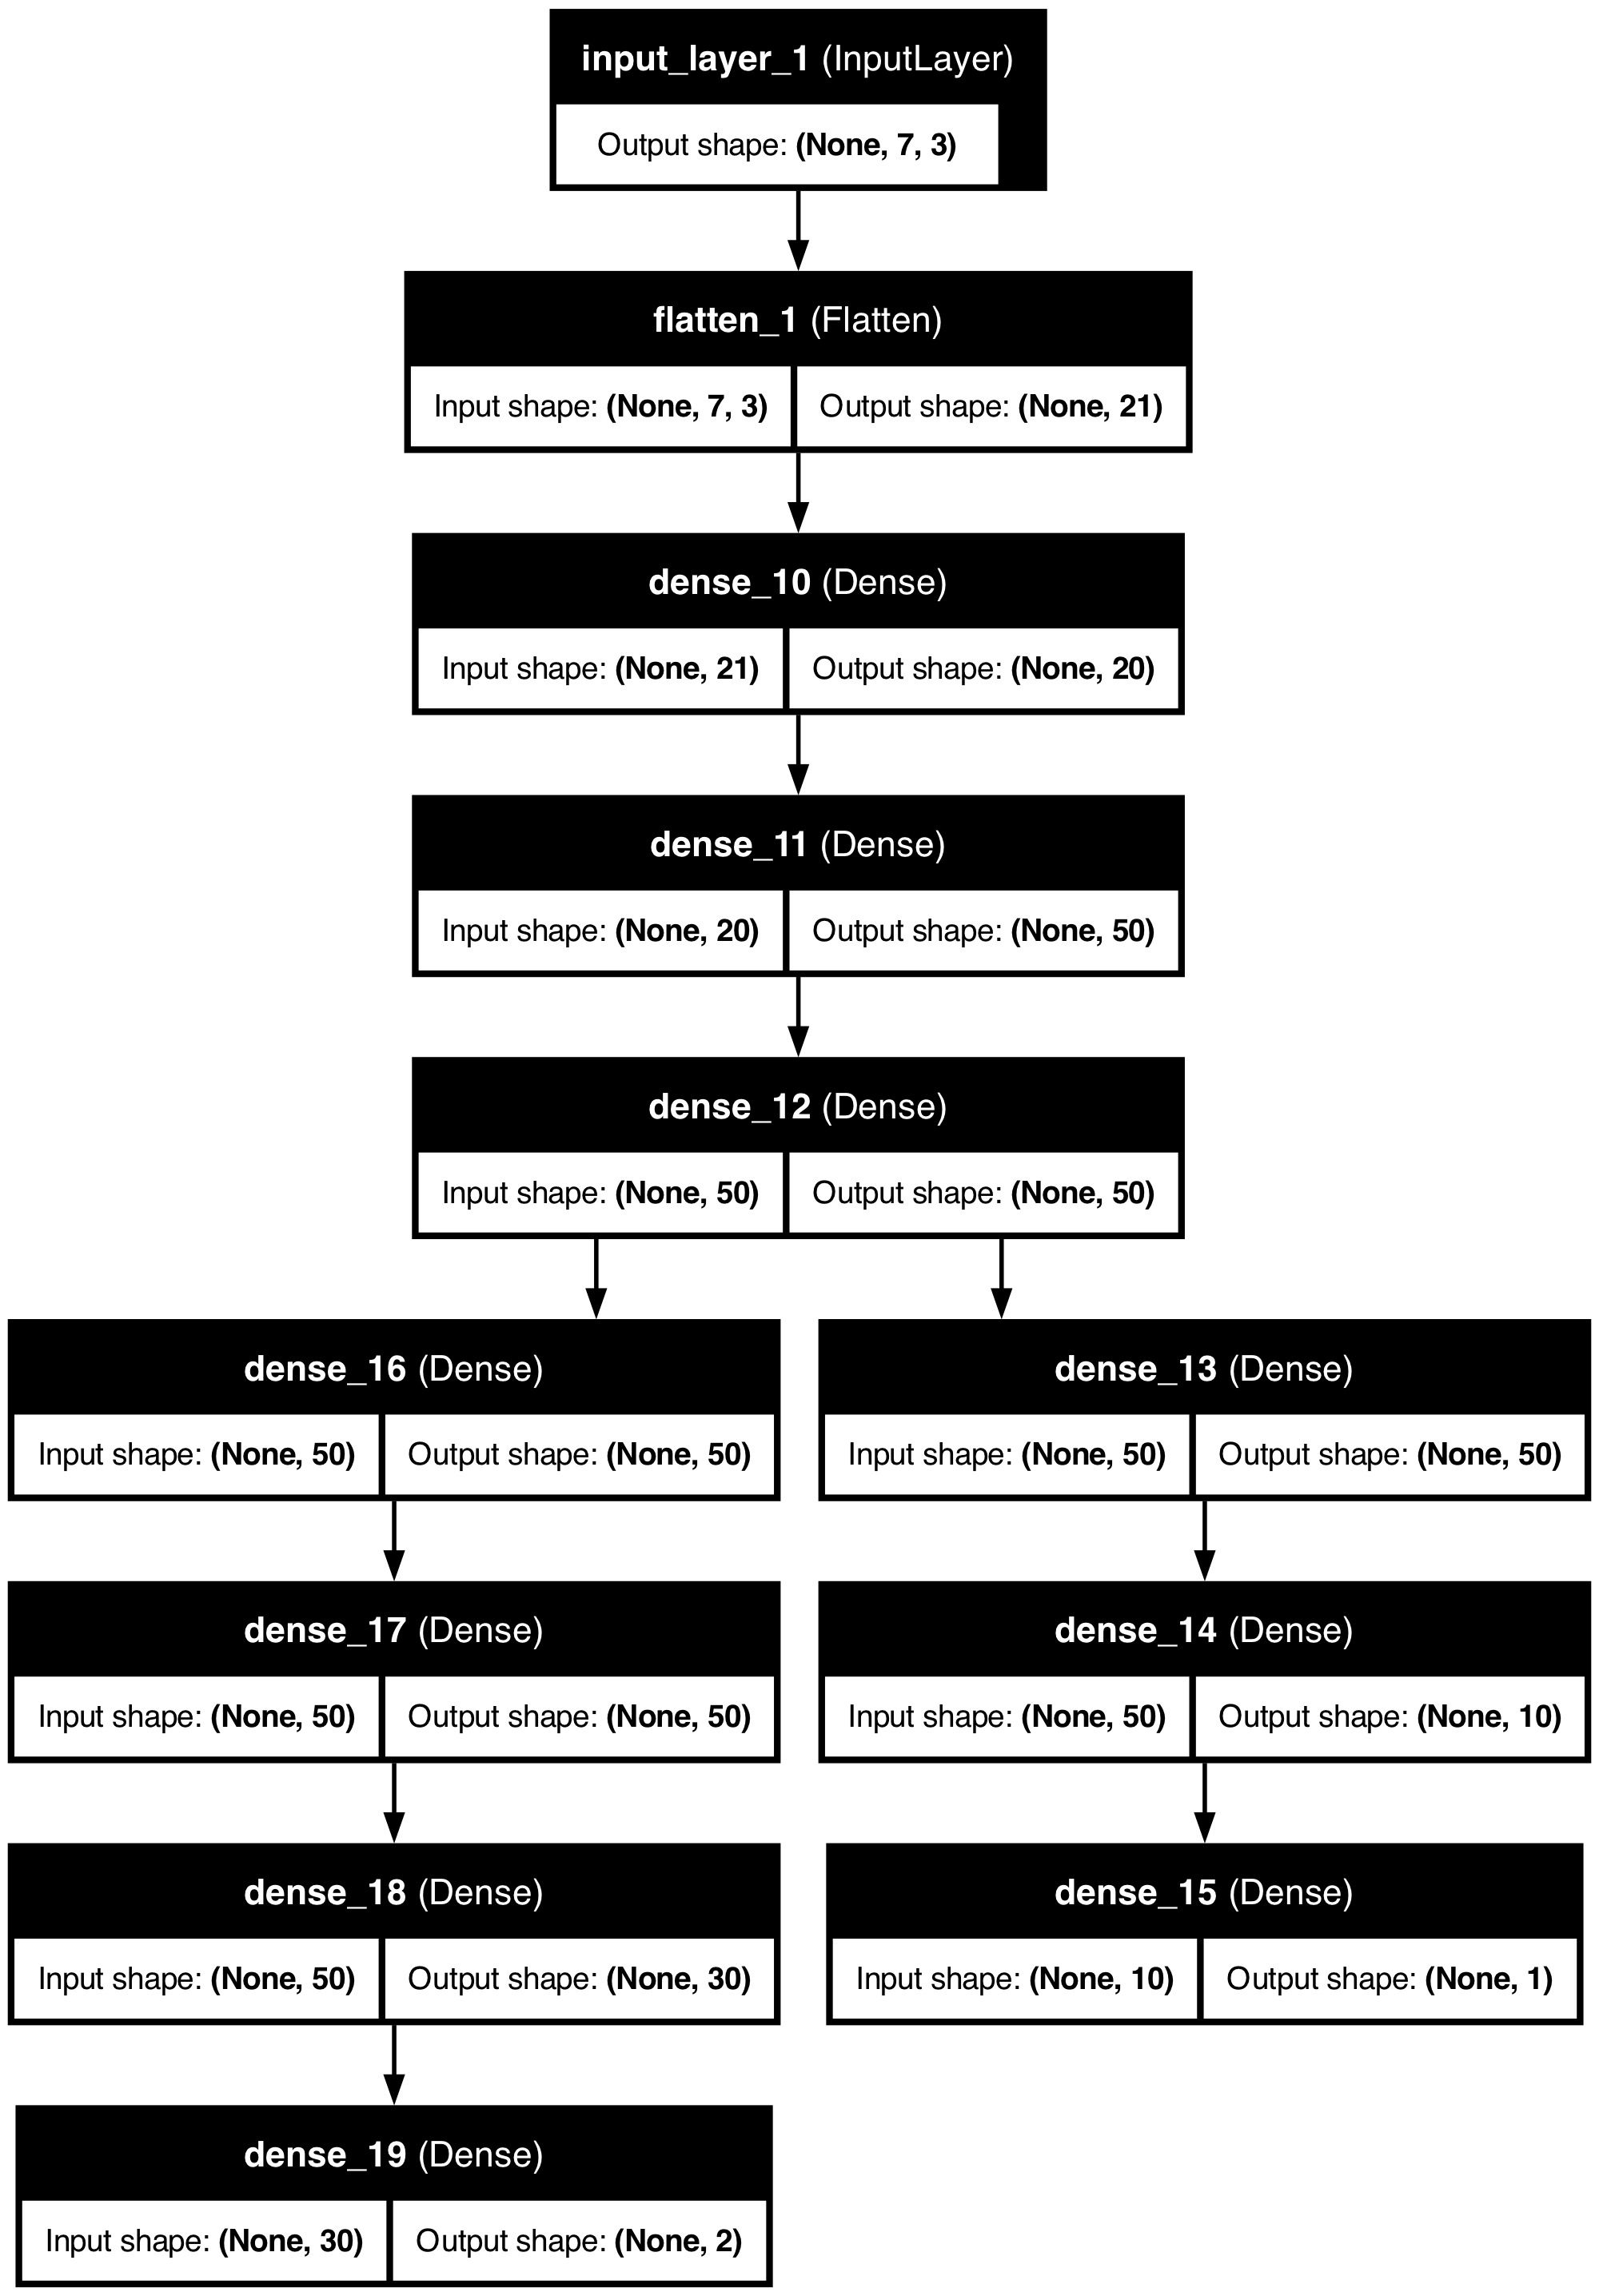

In [5]:
# Creating the FFNN model

# Defining the input layer
input = Input(shape=(7,3))
# Flattening the input (by now no convolutional layer - data are already pretty compressed)
hidden = Flatten()(input)
# Creating some dense layers - the activation is always relu for hidden layers
hidden = Dense(20, activation='relu')(hidden)
hidden = Dense(50, activation='relu')(hidden)
hidden = Dense(50, activation='relu')(hidden)
# Splitting the NN in two 'branches', one for the energy, one for
# the position
hidden_e = Dense(50, activation='relu')(hidden)
hidden_e = Dense(10, activation='relu')(hidden_e)
output_energy = Dense(1, activation='linear')(hidden_e)

hidden_xy = Dense(50, activation='relu')(hidden)
hidden_xy = Dense(50, activation='relu')(hidden_xy)
hidden_xy = Dense(30, activation='relu')(hidden_xy)
output_hit_coordinates = Dense(2, activation='linear')(hidden_xy)

# Defining the outputs
outputs = [output_energy, output_hit_coordinates]
# Defining the loss functions - both MSE for regression
losses = ['MSE', 'MSE']

# Creating the model and compiling it
model = Model(inputs=input, outputs=outputs)

model.compile(loss=losses, optimizer='adam') # those are standard params, see if any better

# Printing the summary
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')


In [11]:
# Defining the path and directory for checkpoints that save the model's weights.
checkpoint_path = "training_1/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [ ]:
# Train the model with the new callback
history=model.fit(X, [target_data[:,0],target_data[:,1:]], epochs=10, validation_split=0.2, callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

In [13]:
print(history.history.keys())
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [12]:
# Load the previously saved weights if provided
model.load_weights(checkpoint_path)

/opt/homebrew/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Model evaluation on test set

In [ ]:
# Loading the test dataset having the same features as the training one
test_data = Xraydata('/Users/chiara/hexsampledata/hxsim_20ENC_01srcsigma_test.h5')

In [ ]:
# Extrapolating input data and predicting the target using the NN
test_input_data, test_target_data = processing_training_data(test_data)


Predicting the data using the NN

In [ ]:
# Pay attention, before prediction, the test data need to be
# scaled (with the same scale as the training data!)!
X_test = scaler.fit_transform(test_input_data.reshape(-1, test_input_data.shape[-1])).reshape(test_input_data.shape)
predicted_data = model.predict(X_test)

In [ ]:
# Checking the result of the prediction ...
print(predicted_data)

In [ ]:
# Comparing the prediction with the MC truth - energy prediction
plt.hist(predicted_data[0], 20, color='red', label='NN prediction')
plt.hist(test_target_data[:,0], 20, alpha=0.5, color='green', label='MC truth')
plt.xlabel('Photon energy [eV]')

plt.legend()

The NN has recognized that there are two distinct peaks and seems like it reduced the regression problem to a classification one. It is necessary to test the NN on a continuum spectrum of energy in order assure if it is the case.

In [ ]:
# Printing the x positions wrt the central px
print(predicted_data[1][:,0])

In [ ]:
# Printing the y positions wrt the central px
print(predicted_data[1][:,1])

The net is not able to learn the position by now, it predicts always the same (x,y) (as if it reduced the task to a classification one, classifying always the same class).

For assuring that the NN 'transformed' a regression task to a classification task, I tried to test it with a dataset having a uniform spectrum in [7000,9000]

In [ ]:
test_data_continuum = Xraydata('/Users/chiara/hexsampledata/hxsim_20ENC_01srcsigma_continuumspectrum.h5')
# Extrapolating input data and predicting the target using the NN
test_c_input_data, test_c_target_data = processing_training_data(test_data_continuum)


In [ ]:
# Pay attention, before prediction, the test data need to be 
# scaled (with the same scale as the training data!!!)!
X_test_c = scaler.fit_transform(test_c_input_data.reshape(-1, test_c_input_data.shape[-1])).reshape(test_c_input_data.shape)
predicted_data_c = model.predict(X_test_c)

In [ ]:
# Checking the results
print(predicted_data_c)

In [ ]:
plt.hist(predicted_data[0], 20, color='red', label='NN prediction')
plt.hist(test_c_target_data[:,0], 20, alpha=0.5, color='green', label='MC truth')
plt.xlabel('Photon energy [eV]')

plt.legend()


As imagined, the network reduced to a classifier unable to predict on a continuum spectrum. It is necessary to change training dataset to a continuum spectrum one in order to avoid the issue (NB: the position has the same problem as with the Cu source, this was expected, the illumination of the pixel hasn't changed). 